In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [2]:
image_size = (150, 150)
batch_size = 32
MODEL = "detectSelfieGrayscale_model"

# Import dataset

In [3]:
# Download selfie dataset from kaggle
if not os.path.exists("data/Selfie-Image-Detection-Dataset"):
    # Instruction for installing credential at https://github.com/Kaggle/kaggle-api
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    # Selfie dataset at https://www.kaggle.com/jigrubhatt/selfieimagedetectiondataset
    # Download to sub-directory data/
    api.dataset_download_files('jigrubhatt/selfieimagedetectiondataset', 'data/', unzip=True)

In [13]:
# Set up training and validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Selfie-Image-Detection-Dataset-Grayscale/Training_data",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Selfie-Image-Detection-Dataset-Grayscale/Validation_data",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 62895 files belonging to 2 classes.
Found 7862 files belonging to 2 classes.


In [14]:
# Show class names of the dataset
class_names = train_ds.class_names
print(class_names)

['NonSelfie', 'Selfie']


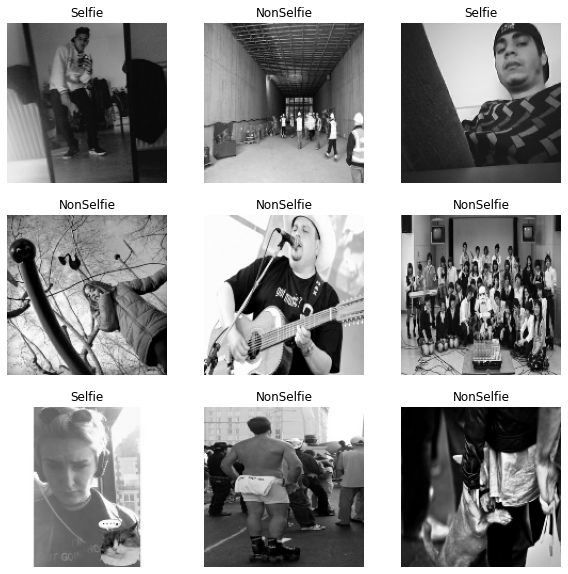

In [15]:
# Visualize the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Create transfer learning model

In [16]:
# Import Xception model
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)

# Freeze the base model
base_model.trainable = False

In [17]:
# Set up data augmentation preprocessing layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.3, 0.3),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    ]
)

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

In [18]:
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Train model

In [19]:
# Train model
epochs = 5

model.summary()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
train_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

In [20]:
import pandas as pd
# convert the train_history.history dict to a pandas DataFrame:     
train_hist_df = pd.DataFrame(train_history.history) 

# save to json:  
hist_json_file = 'train_history_grayscale.json' 
with open(hist_json_file, mode='w') as f:
    train_hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'train_history_grayscale.csv'
with open(hist_csv_file, mode='w') as f:
    train_hist_df.to_csv(f)

In [21]:
# Creates a SavedModel
model.save(MODEL)

INFO:tensorflow:Assets written to: detectSelfieGrayscale_model/assets


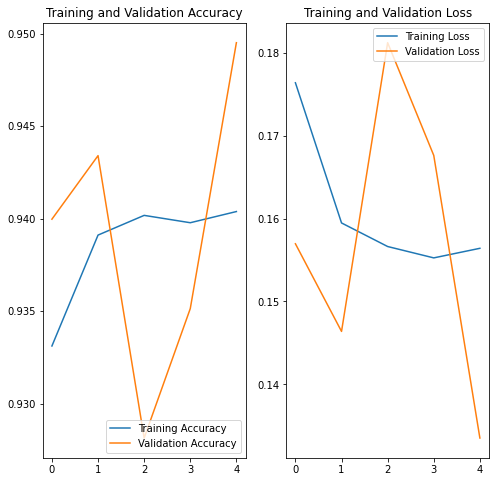

In [22]:
# Evaluate training
acc = train_history.history['binary_accuracy']
val_acc = train_history.history['val_binary_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Fine-tuning model
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 3

fine_tuning_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

In [24]:
# convert the fine_tuning_history.history dict to a pandas DataFrame:     
fine_tuning_hist_df = pd.DataFrame(fine_tuning_history.history) 

# save to json:  
hist_json_file = 'fine_tuning_history_grayscale.json' 
with open(hist_json_file, mode='w') as f:
    fine_tuning_hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'fine_tuning_history_grayscale.csv'
with open(hist_csv_file, mode='w') as f:
    fine_tuning_hist_df.to_csv(f)

In [25]:
# Creates a SavedModel
model.save("final_detectSelfieGrayscale_model")

INFO:tensorflow:Assets written to: final_detectSelfieGrayscale_model/assets


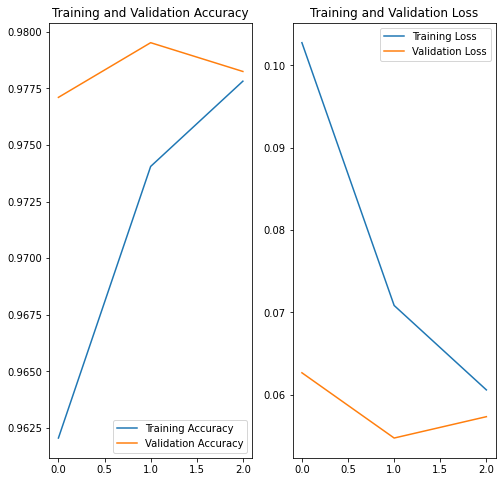

In [26]:
#Evaluate fine-tuning
acc = fine_tuning_history.history['binary_accuracy']
val_acc = fine_tuning_history.history['val_binary_accuracy']

loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate accuracy

In [27]:
# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/Selfie-Image-Detection-Dataset/Test_data",
    labels='inferred',
    label_mode='int',
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 7862 files belonging to 2 classes.


Image is a Selfie
[0.99971765]


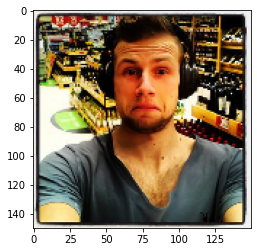

In [28]:
# Usage: making a single prediction
image_path = "data/Selfie-Image-Detection-Dataset/Test_data/Selfie/Selfie42906.jpg"
img = keras.preprocessing.image.load_img(image_path, target_size=image_size)

plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]

if (score > 0.5):
    print("Image is a Selfie")
    print(score)
else:
    print("Image is not a Selfie")
    print(score)

In [30]:
# predictions on test dataset
predictions = np.array([])
labels =  np.array([])
for images, y in test_ds:
    for i in range(len(y)):
        scores = model.predict(images)
        if (scores[i] > 0.5):
            prediction = np.ones(1)
        else:
            prediction = np.zeros(1)
        predictions = np.concatenate([predictions, prediction])
        labels = np.concatenate([labels, np.array([y.numpy()[i]])])

In [31]:
# Total error count
print('Number of errors :', sum(x != 0 for x in (predictions - labels)), 'out of', len(predictions))

Number of errors : 93 out of 7862


In [32]:
# Accuracy score
from sklearn.metrics import accuracy_score 
print('accuracy_score :', accuracy_score(labels, predictions))

accuracy_score : 0.9881709488679725


In [33]:
# Mean squared error
from sklearn.metrics import mean_squared_error
print('mean_squared_error :', mean_squared_error(labels, predictions))

mean_squared_error : 0.011829051132027474


In [34]:
# Plot confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[3856   75]
 [  18 3913]]
Normalized confusion matrix
[[0.98 0.02]
 [0.   1.  ]]


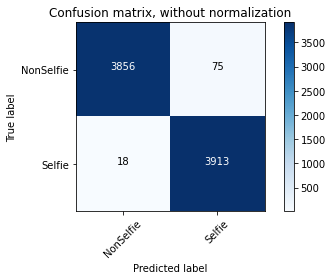

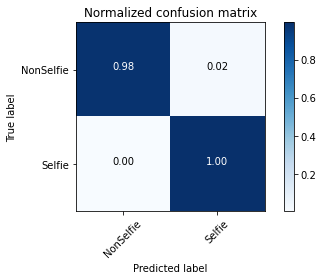

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=test_ds.class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# Remove used data
shutil.rmtree("data/Selfie-Image-Detection-Dataset")